Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

Base functions

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)


def calculate_mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

def evaluate_model(model, df_test):
    X_test = df_test['x'].values.reshape(-1, 1)
    y_test = df_test['y'].values.reshape(-1, 1)
    predictions = np.array([model.feedforward(x.reshape(-1, 1))[0] for x in X_test])

    # Flatten predictions to ensure it has the same shape as y_test
    predictions = predictions.reshape(-1, 1)
    
    for i in range(len(predictions)):
        #print(predictions[i], y_test[i])
        pass
    mse_score = calculate_mse(predictions, y_test)

    #print(f"MSE Score: {mse_score}")
    return mse_score

Set the seed for generating weights randomly

In [43]:
np.random.seed(42)

MLP Class with all parts of our network

In [28]:
class MLP:
    def __init__(self, layer_sizes, init_method='xavier', weights=None):
        self.layer_sizes = layer_sizes
        
        if weights:
            self.weights = weights
        else: 
            if init_method == 'uniform':
                self.weights = [np.random.rand(y, x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
            elif init_method == 'he':
                self.weights = [np.random.randn(y, x) * np.sqrt(2. / x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
            elif init_method == 'xavier':
                self.weights = [np.random.randn(y, x) * np.sqrt(1. / x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.random.rand(y, 1) for y in layer_sizes[1:]]
        
        print(f"Weights: {self.weights}")


    def print_final_weights_and_biases(self):
        print("Final Weights and Biases:")
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            print(f"Layer {i + 1} Weights:\n{w}")
            print(f"Layer {i + 1} Biases:\n{b}")
            
    def plot_weights(self):
        for i, w in enumerate(self.weights):
            plt.figure(figsize=(8, 2))
            plt.hist(w.flatten(), bins=50)
            plt.title(f'Layer {i+1} Weight Distribution')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.show()

    def feedforward(self, a):
        activations = [a]
        for b, w in zip(self.biases[:-1], self.weights[:-1]):  # Use ReLU for hidden layers
            a = relu(np.dot(w, a) + b)
            activations.append(a)
        # Linear activation for the last layer
        a = np.dot(self.weights[-1], a) + self.biases[-1]
        activations.append(a)
        return activations[-1], activations

    def backprop(self, x, y, clip_value=1.0):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        final_output, activations = self.feedforward(x)
        zs = [np.dot(w, act) + b for w, b, act in zip(self.weights, self.biases, activations[:-1])]  # Z values
        
        # Output layer error
        delta = self.cost_derivative(final_output, y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate the error using ReLU derivative
        for l in range(2, len(self.layer_sizes)):
            sp = relu_derivative(zs[-l])
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)

        return nabla_w, nabla_b

    def update_mini_batch(self, mini_batch, learning_rate, lambda_, n):
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        for x, y in mini_batch:
            delta_nabla_w, delta_nabla_b = self.backprop(x, y)
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]

        # Update weights with L2 regularization
        self.weights = [(1 - learning_rate * (lambda_ / n)) * w - (learning_rate / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (learning_rate / len(mini_batch)) * nb for b, nb in zip(self.biases, nabla_b)]

    def train(self, training_data, epochs, learning_rate, batch_size, lambda_=0.0, update_method='batch', plot_interval=None):
        n = len(training_data)
        learning_rate_init = learning_rate
        for j in range(epochs):
            # Plot weights at the specified interval
            if plot_interval and j % plot_interval == 0:
                print(f"Epoch {j}:")
                self.plot_weights()
                
                
            np.random.shuffle(training_data)
            if update_method == 'batch':
                mini_batches = [training_data[k:k + batch_size] for k in range(0, n, batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, learning_rate, lambda_, n)
            elif update_method == 'epoch':
                self.update_mini_batch(training_data, learning_rate, lambda_, n)
                
            
            # Learning rate schedule
            learning_rate = learning_rate_init / (1 + 0.01 * j)
            
            

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)

Read the data

In [5]:
df_train_square = pd.read_csv('mio1/regression/square-simple-training.csv')
X_train_square = df_train_square['x'].values.reshape(-1, 1)
y_train_square = df_train_square['y'].values.reshape(-1, 1)

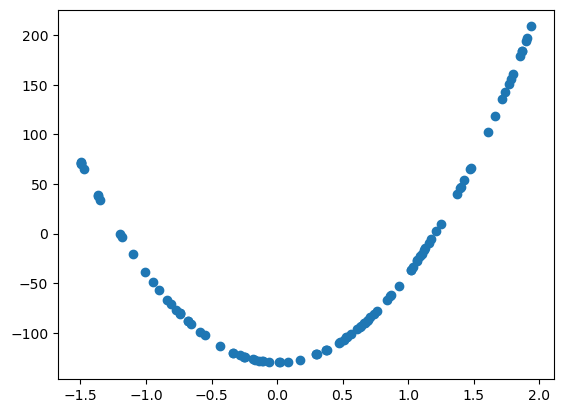

In [26]:
import matplotlib.pyplot as plt

plt.scatter(X_train_square, y_train_square)
plt.show()

Read the test data

In [6]:
df_test_square = pd.read_csv('mio1/regression/square-simple-test.csv')
X_test_square = df_test_square['x'].values.reshape(-1, 1)
y_test_square = df_test_square['y'].values.reshape(-1, 1)

Train our network

Epoch 0:


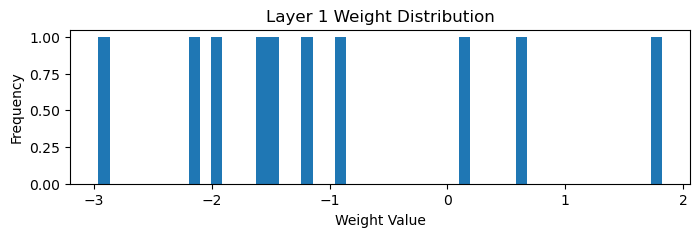

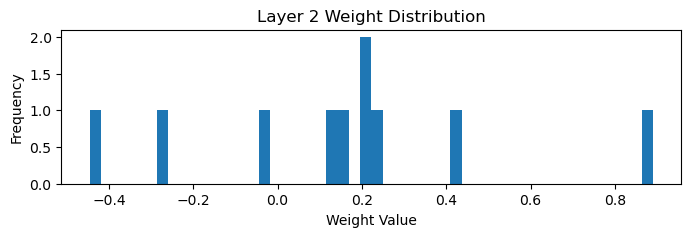

KeyboardInterrupt: 

In [208]:
mlp_square_1_5 = MLP([1, 10, 1])
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square, y_train_square)]
mlp_square_1_5.train(training_data, epochs=50000, learning_rate=0.01, batch_size=10, plot_interval=10000)


In [154]:
evaluate_model(mlp_square_1_5, df_test_square)

15.968277396610706

In [ ]:
mlp_square_1_5.print_final_weights_and_biases()

Try with lower learning rate of 0.001

Weights: [array([[ 1.19232672],
       [ 0.51175051],
       [-0.94266336],
       [-1.71550958],
       [ 1.85374345],
       [-0.53013872],
       [ 1.51036727],
       [ 2.39211851],
       [-0.60867855],
       [ 0.35099043]]), array([[-0.01514429, -0.10621507, -0.04668507, -0.22137475, -0.24756226,
         0.06956   , -0.19295246,  0.41889734, -0.05001299, -0.13793619]])]
Epoch 0:


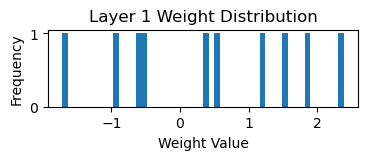

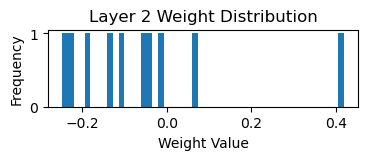

Epoch 999:


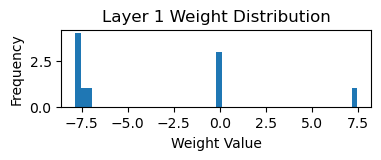

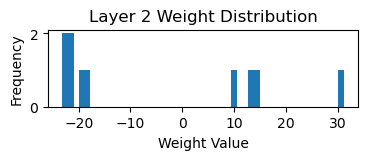

In [127]:
mlp_square_1_5 = MLP([1, 10, 1])
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square, y_train_square)]
mlp_square_1_5.train(training_data, epochs=1000, learning_rate=0.001, batch_size=10, plot_interval=999)

In [128]:
predictions = np.array([mlp_square_1_5.feedforward(x.reshape(-1, 1))[0] for x in X_test_square])

# Flatten predictions to ensure it has the same shape as y_test
predictions = predictions.reshape(-1, 1)

In [129]:
for i in range(len(predictions)):
    print(predictions[i], y_test_square[i])
mse_score = mse(predictions, y_test_square)

print(f"MSE Score: {mse_score}")

[-72.369576] [-43.4869178]
[-72.36998773] [3.7528081]
[-72.319464] [-128.61072132]
[14.35328838] [5.67182845]
[-30.2066743] [-27.46916942]
[48.78581361] [36.53905322]
[-72.3694387] [-56.38035958]
[83.49466574] [163.71667642]
[-72.36817848] [-109.92253645]
[-72.36957211] [-43.87280887]
[-40.6882097] [-36.76289151]
[-72.36732141] [-117.96377078]
[13.77773425] [5.24004298]
[-72.36035716] [-128.71571315]
[-59.89040167] [-61.08193105]
[10.69129209] [2.94504249]
[-72.36932158] [-66.12375418]
[-72.3702908] [45.94659944]
[-72.36965446] [-35.44343445]
[-59.40696111] [-60.21294992]
[83.021743] [152.56039396]
[-71.90196286] [-113.61118977]
[-70.59160108] [-96.92892366]
[-72.36925848] [-70.87526302]
[-72.05537071] [-117.45634919]
[-72.36937731] [-61.6352831]
[-72.3327326] [-129.40068949]
[-72.3675702] [-116.2889997]
[-72.36977303] [-22.4051127]
[-72.36933355] [-65.18253908]
[-33.22415291] [-30.00706095]
[-72.35574967] [-129.69254744]
[-72.35501534] [-129.76750355]
[-72.29374483] [-127.04872533]
[-

We see that even when we lower learning rate same issue persists

Lets see how it should look like inputting tested weights that cause our network to learn correctly

In [48]:
tested_weights =[np.array([[-1.72653365],
       [ 0.05844975],
       [ 0.02480807],
       [-1.43801207],
       [-1.61864485]]), np.array([[-0.33103953,  0.46161234,  0.52898723, -0.19594812, -1.20473079],
       [ 0.10714178,  1.02336539, -0.43787058,  1.00746338, -0.02692385],
       [ 0.66009404,  0.73762201, -0.33773318, -0.0590014 ,  0.39356462],
       [ 0.00436065, -0.79771949,  0.08369935,  0.34033373, -0.24311589],
       [-0.80227471,  1.1389214 ,  0.34726943,  0.73367075,  0.12756819]]), np.array([[ 0.0409861 ,  0.77876792, -0.06783529, -0.16359052,  0.6540905 ]])]

Weights: [array([[-1.72653365],
       [ 0.05844975],
       [ 0.02480807],
       [-1.43801207],
       [-1.61864485]]), array([[-0.33103953,  0.46161234,  0.52898723, -0.19594812, -1.20473079],
       [ 0.10714178,  1.02336539, -0.43787058,  1.00746338, -0.02692385],
       [ 0.66009404,  0.73762201, -0.33773318, -0.0590014 ,  0.39356462],
       [ 0.00436065, -0.79771949,  0.08369935,  0.34033373, -0.24311589],
       [-0.80227471,  1.1389214 ,  0.34726943,  0.73367075,  0.12756819]]), array([[ 0.0409861 ,  0.77876792, -0.06783529, -0.16359052,  0.6540905 ]])]
Epoch 0:


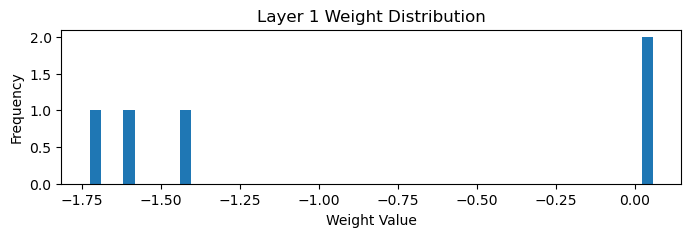

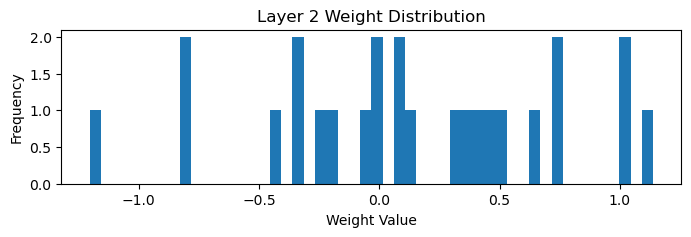

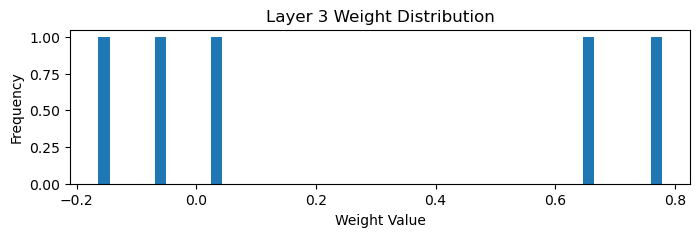

Epoch 100:


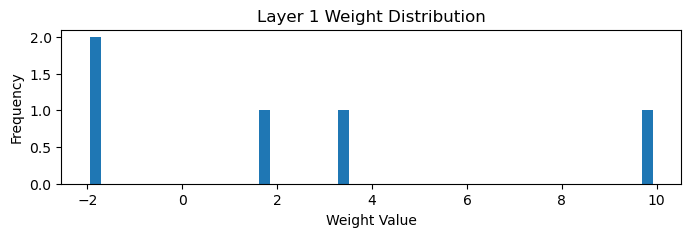

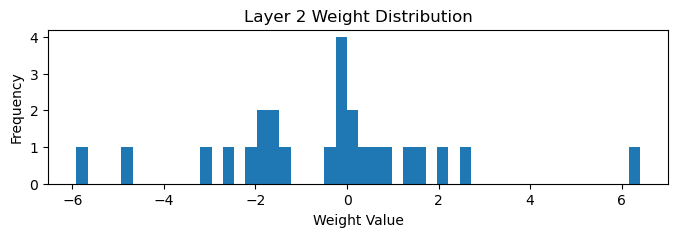

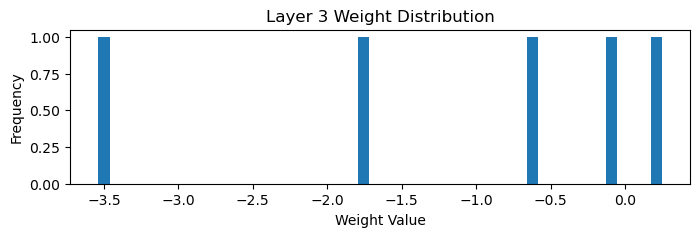

Epoch 200:


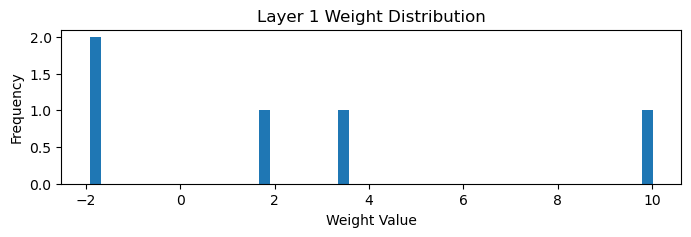

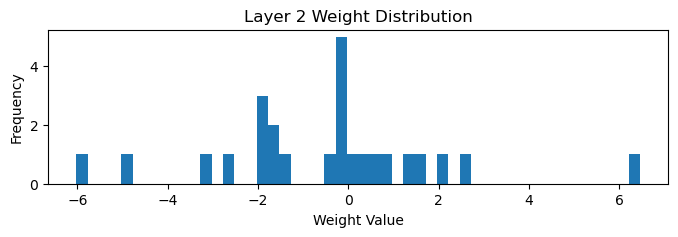

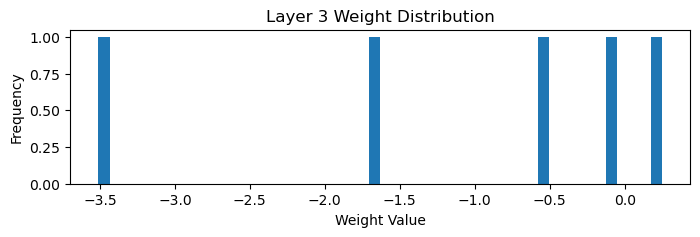

Epoch 300:


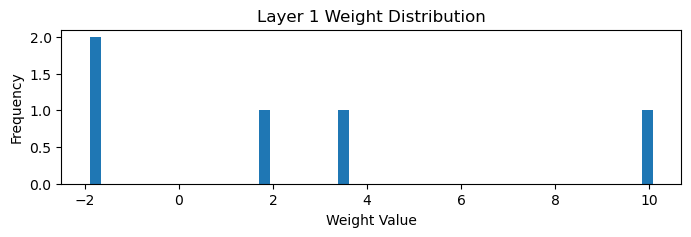

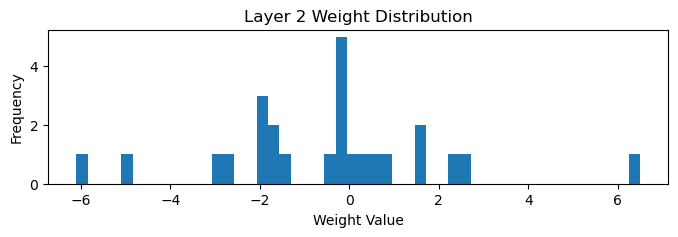

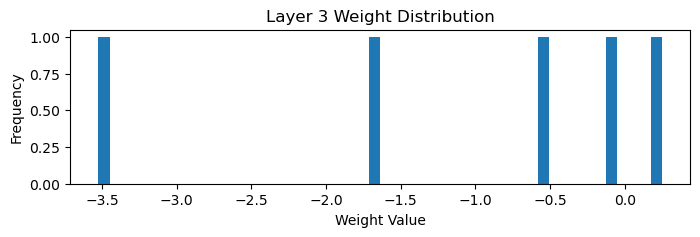

Epoch 400:


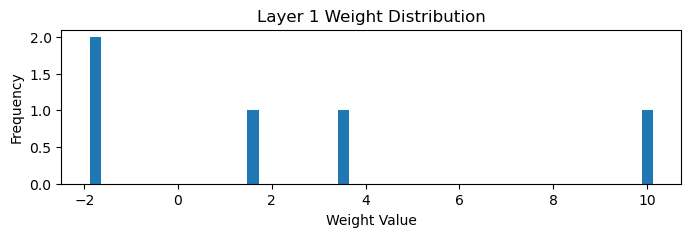

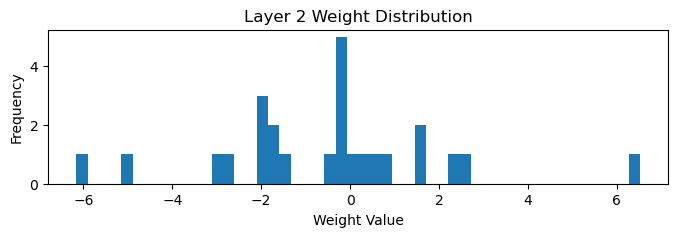

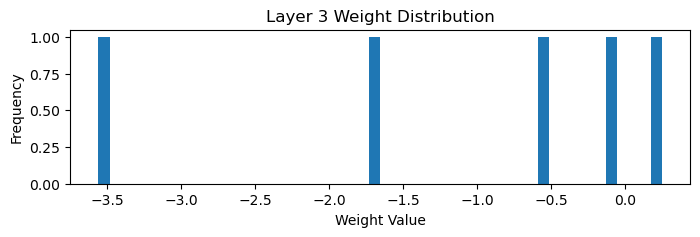

Epoch 500:


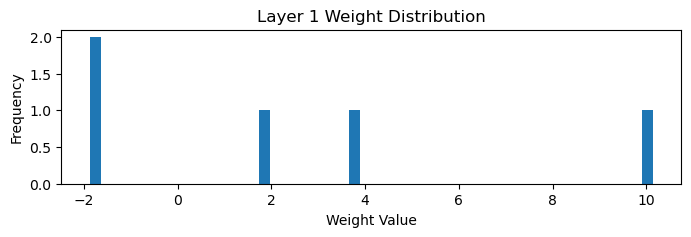

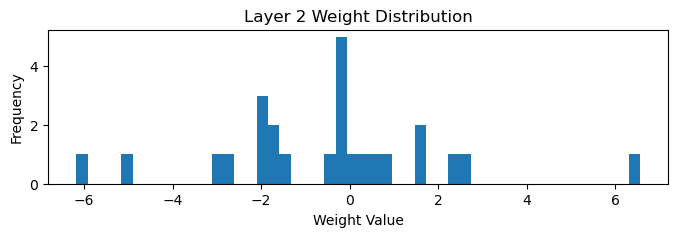

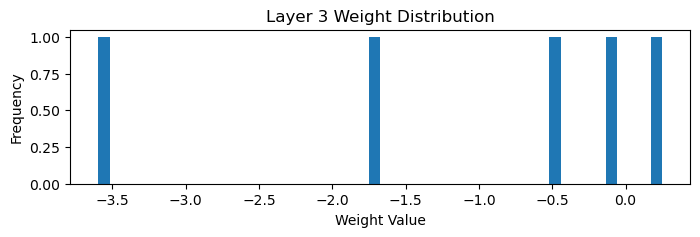

Epoch 600:


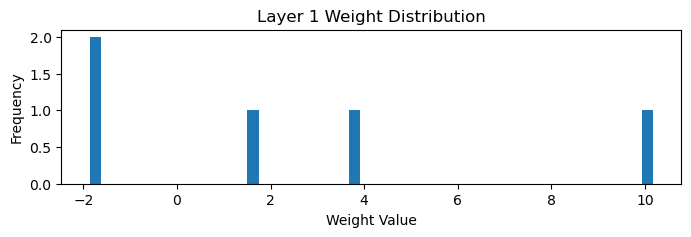

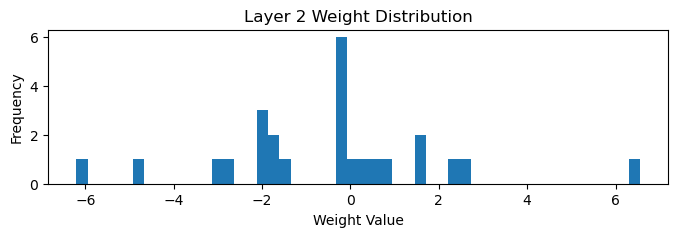

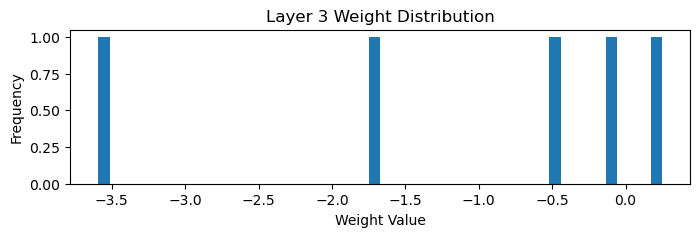

Epoch 700:


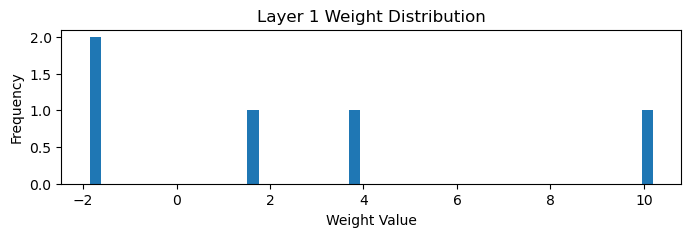

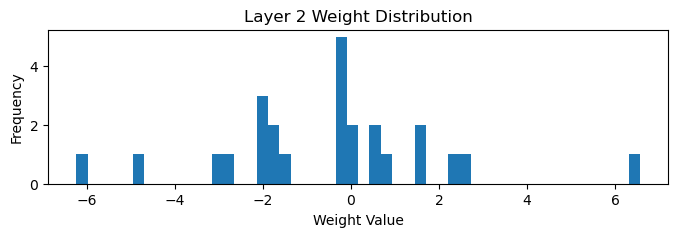

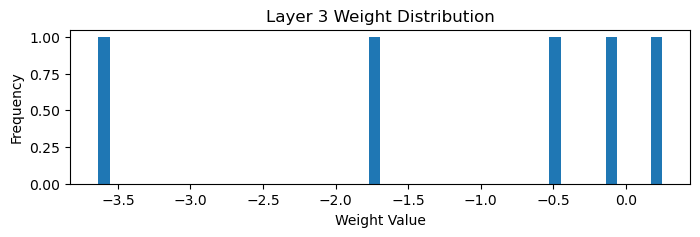

Epoch 800:


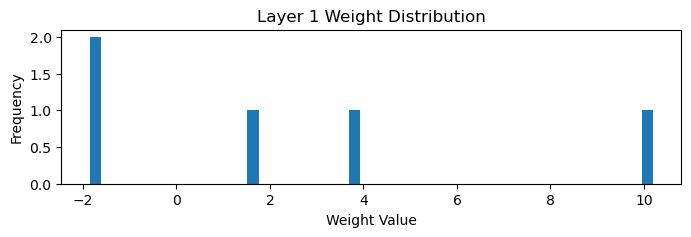

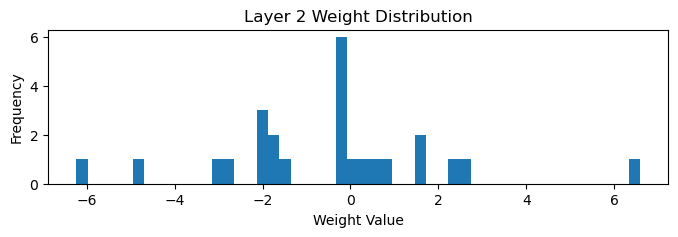

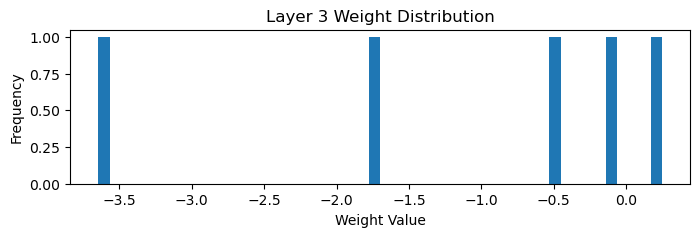

Epoch 900:


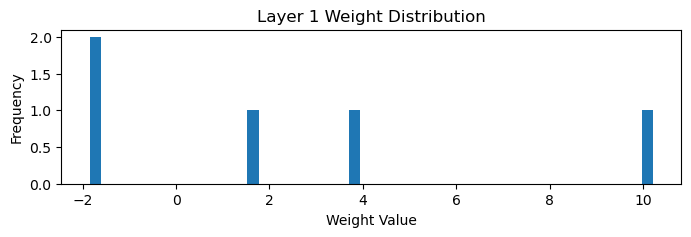

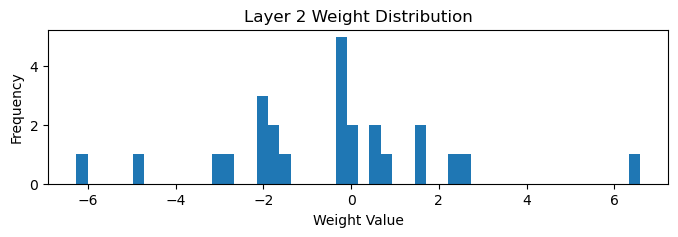

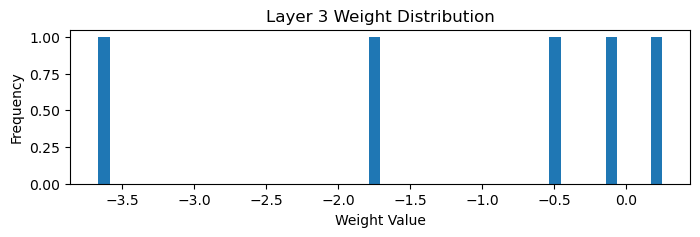

In [62]:
mlp_square_1_5 = MLP([1, 5, 5, 1], weights=tested_weights)
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square, y_train_square)]
mlp_square_1_5.train(training_data, epochs=1000, learning_rate=0.001, batch_size=10, plot_interval=100)


In [63]:
predictions = np.array([mlp_square_1_5.feedforward(x.reshape(-1, 1))[0] for x in X_test_square])

# Flatten predictions to ensure it has the same shape as y_test
predictions = predictions.reshape(-1, 1)

# Calculate MSE score
for i in range(len(predictions)):
    print(predictions[i], y_test_square[i])
mse_score = calculate_mse(predictions, y_test_square)
print(f"MSE Score: {mse_score}")

[-27.72902656] [-43.4869178]
[4.25793142] [3.7528081]
[-167.3863429] [-128.61072132]
[2.8658613] [5.67182845]
[-21.81858669] [-27.46916942]
[23.25428708] [36.53905322]
[-37.91680836] [-56.38035958]
[43.5707437] [163.71667642]
[-95.83745048] [-109.92253645]
[-28.02244807] [-43.87280887]
[-29.43786694] [-36.76289151]
[-110.12844026] [-117.96377078]
[2.56502742] [5.24004298]
[-143.1347965] [-128.71571315]
[-51.40053345] [-61.08193105]
[0.95793058] [2.94504249]
[-46.2236623] [-66.12375418]
[28.26787374] [45.94659944]
[-21.75555834] [-35.44343445]
[-50.55440006] [-60.21294992]
[43.5707437] [152.56039396]
[-120.3803291] [-113.61118977]
[-92.77083583] [-96.92892366]
[-50.50477164] [-70.87526302]
[-128.59631208] [-117.45634919]
[-42.32355988] [-61.6352831]
[-170.08476543] [-129.40068949]
[-106.82916713] [-116.2889997]
[-12.58897568] [-22.4051127]
[-45.3947451] [-65.18253908]
[-23.86369438] [-30.00706095]
[-151.31240553] [-129.69254744]
[-152.33400937] [-129.76750355]
[-158.17362241] [-127.0487

## Grid Search

In [163]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [10, 20, 50],
    'lambda_': [0.0, 0.01, 0.1],
    'layer_configurations': [
    [5],          # 1 layer with 5 neurons
    [10],          # 1 layer with 10 neurons
    [5,5]  # 2 layers, 5 neurons each
    ],
    'weight_init_methods': [
        'uniform',
        'he',
        'xavier'
    ]
 
}

In [183]:
# Best parameter tracking
best_params = None
best_mse = float('inf')

# Iterate over all combinations of parameters
for learning_rate, batch_size, lambda_, layer_config, init_method in itertools.product(*param_grid.values()):
    # Initialize and train your MLP model with the current set of parameters
    model = MLP(layer_sizes=[1] + layer_config + [1], init_method=init_method)  # Define your layer_sizes accordingly
    model.train(training_data, epochs=100, learning_rate=learning_rate, batch_size=batch_size, lambda_=lambda_)
    
    # Evaluate the model
    mse = evaluate_model(model, df_test_square)  # Define your validation_data
    
    # Update best parameters if current MSE is lower
    if mse < best_mse:
        best_mse = mse
        best_params = {'learning_rate': learning_rate, 'batch_size': batch_size, 'lambda_': lambda_, 'layer_configuration': layer_config,
        'init_method': init_method}

print(f"Best Parameters: {best_params}, Best MSE: {best_mse}")

Weights: [array([[0.4921301 ],
       [0.35922906],
       [0.21706215],
       [0.84350685],
       [0.59008996]]), array([[0.80648382, 0.56715865, 0.80771749, 0.06511927, 0.58519714]])]
Weights: [array([[ 0.54893111],
       [ 1.19540707],
       [-0.95546728],
       [-1.41138692],
       [ 1.38370628]]), array([[ 0.51883826,  0.45013437, -0.49776345, -0.31499159,  0.59020351]])]
Weights: [array([[ 0.20317666],
       [ 0.0700508 ],
       [ 0.7963427 ],
       [-0.26377845],
       [ 0.55682367]]), array([[ 0.73819749, -0.05360626, -0.63896213, -0.13961037, -0.33519677]])]
Weights: [array([[0.58704078],
       [0.35407678],
       [0.68002126],
       [0.3289743 ],
       [0.54889251],
       [0.37189574],
       [0.69419923],
       [0.67727244],
       [0.87935693],
       [0.25917423]]), array([[0.36355956, 0.4543296 , 0.16789259, 0.12888753, 0.13251441,
        0.49821766, 0.28647143, 0.98479117, 0.65556968, 0.62210663]])]
Weights: [array([[-0.11225685],
       [ 1.87823412],
 

Weights: [array([[0.90551664],
       [0.56417566],
       [0.15346856],
       [0.12981476],
       [0.48698895]]), array([[0.28133342, 0.11192118, 0.33179812, 0.28680232, 0.3651527 ],
       [0.74755481, 0.74071457, 0.03924881, 0.16607353, 0.19258022],
       [0.40587275, 0.0979349 , 0.17416737, 0.90621708, 0.1209695 ],
       [0.93827361, 0.8703046 , 0.60537925, 0.70223409, 0.92138567],
       [0.50285242, 0.06674985, 0.36658834, 0.07467169, 0.08526584]]), array([[0.63381787, 0.36578362, 0.27726719, 0.12123028, 0.35646933]])]
Weights: [array([[-1.03765002],
       [ 0.34303481],
       [-0.33749694],
       [ 3.2918358 ],
       [ 0.64374557]]), array([[-0.45428713,  1.26512731,  0.37298186,  0.3727123 ,  0.56587145],
       [-0.57119043,  0.44278226,  0.15860452, -0.50895439,  0.23496099],
       [-1.23868319, -0.23239033,  0.88219553, -0.36368459, -0.06378998],
       [ 0.55837746,  0.33019664,  0.44220538, -0.02796684, -0.23395966],
       [ 0.56665339,  0.4632791 ,  0.26167725, 

Weights: [array([[0.05606186],
       [0.55410805],
       [0.38091585],
       [0.59363749],
       [0.00743216]]), array([[0.03040872, 0.60106312, 0.38607535, 0.79516198, 0.31535301]])]
Weights: [array([[ 0.29347995],
       [-0.43626546],
       [ 0.30929371],
       [-1.08416568],
       [ 0.04132199]]), array([[ 0.25054251,  0.42568082, -0.17396153, -0.65921726, -0.32036423]])]
Weights: [array([[ 0.0056799 ],
       [ 0.26174401],
       [ 0.39219862],
       [-0.07211802],
       [-1.05806601]]), array([[ 0.22421448, -0.33234098,  0.11439001, -0.41511968,  1.11174172]])]
Weights: [array([[0.76251319],
       [0.54783133],
       [0.97235603],
       [0.28720133],
       [0.61201316],
       [0.92129299],
       [0.2808437 ],
       [0.74249187],
       [0.89945016],
       [0.3991415 ]]), array([[0.61518601, 0.60003488, 0.46640356, 0.3603024 , 0.91603474,
        0.14138436, 0.47437392, 0.31399238, 0.59893671, 0.54465023]])]
Weights: [array([[-0.50938934],
       [ 0.35799406],
 

Weights: [array([[0.26992216],
       [0.9644549 ],
       [0.83043688],
       [0.8666369 ],
       [0.21377425]]), array([[0.88315844, 0.26667603, 0.30400178, 0.00398934, 0.98487088],
       [0.67181679, 0.27429947, 0.32572747, 0.54572635, 0.38791957],
       [0.07380648, 0.77182255, 0.77181939, 0.79136021, 0.0713499 ],
       [0.56086633, 0.1015365 , 0.06061437, 0.87190737, 0.34058808],
       [0.21758322, 0.87932923, 0.89550597, 0.63030292, 0.91035772]]), array([[0.98177672, 0.20191175, 0.3895574 , 0.70644969, 0.10034587]])]
Weights: [array([[-0.63205192],
       [ 0.23168022],
       [-0.58824826],
       [-0.28645596],
       [ 0.20950265]]), array([[ 9.34919505e-01, -7.40022374e-02,  9.70110631e-01,
        -9.96061162e-01,  2.61877839e-02],
       [-3.18883788e-01, -2.38295084e-01,  4.58786401e-01,
         9.63840191e-01,  8.03285003e-01],
       [-8.51294811e-01,  5.34846110e-01,  3.36441402e-01,
         1.04551892e-03, -5.52620507e-01],
       [-1.43962607e+00,  1.72408581e

Weights: [array([[0.81162211],
       [0.66785247],
       [0.01225321],
       [0.28100631],
       [0.98384205]]), array([[0.54633443, 0.22909318, 0.03204615, 0.33957322, 0.33449166]])]
Weights: [array([[-1.90442485],
       [ 2.1831212 ],
       [-1.68317032],
       [-0.76109559],
       [ 0.00334541]]), array([[ 0.21270391, -0.08168055, -0.31052444, -1.28606678,  0.3854186 ]])]
Weights: [array([[ 0.03299076],
       [-0.18409232],
       [-1.03166913],
       [-0.3390155 ],
       [-0.85500999]]), array([[ 0.65661935, -0.36985629, -0.06800499, -0.2329119 ,  0.36910144]])]
Weights: [array([[0.28506138],
       [0.8741819 ],
       [0.85771072],
       [0.60721318],
       [0.26843152],
       [0.3645524 ],
       [0.42485174],
       [0.11213169],
       [0.0796465 ],
       [0.64041604]]), array([[0.40506642, 0.88076919, 0.56724075, 0.8960875 , 0.2194824 ,
        0.67009058, 0.78620964, 0.67559127, 0.66883049, 0.42930142]])]
Weights: [array([[ 1.68924676],
       [-1.62893967],
 

Weights: [array([[0.44500913],
       [0.93043123],
       [0.60607523],
       [0.79676162],
       [0.11348727]]), array([[0.84917348, 0.74659267, 0.62489014, 0.04214224, 0.73008405],
       [0.44285346, 0.95952622, 0.89088182, 0.42078377, 0.36627372],
       [0.57624847, 0.17584608, 0.68122509, 0.31501403, 0.85093471],
       [0.2479888 , 0.13163009, 0.73167214, 0.1579253 , 0.88478748],
       [0.02101511, 0.44813855, 0.54851961, 0.34835705, 0.98780716]]), array([[0.10209279, 0.58969479, 0.45732338, 0.37478173, 0.28012395]])]
Weights: [array([[-2.39350494],
       [-0.75127142],
       [ 1.277481  ],
       [-3.06536127],
       [ 1.48701798]]), array([[-0.65326964, -0.15072878,  0.01692113,  0.35362791,  0.34462942],
       [-0.67696098, -0.6353227 ,  0.72270271,  0.73982966, -0.04103188],
       [ 0.36414316,  0.36531553, -0.98470017, -1.10093673, -0.71384771],
       [ 0.78713267,  0.61030476,  1.21769233,  0.36789908,  0.12642835],
       [ 0.13821664,  0.36638612,  0.58654549, 

Weights: [array([[0.23386113],
       [0.3144078 ],
       [0.22593603],
       [0.03667827],
       [0.41158492]]), array([[0.23968902, 0.42671789, 0.4444611 , 0.24895418, 0.51154346]])]
Weights: [array([[ 0.05620402],
       [ 0.76435644],
       [ 1.51658035],
       [ 0.04009409],
       [-1.69660392]]), array([[-0.36043215, -0.41000367,  0.25166385,  0.34539157, -0.37713951]])]
Weights: [array([[-0.60697362],
       [ 0.16221978],
       [ 0.80505177],
       [ 0.5060538 ],
       [-1.15984938]]), array([[-0.26800479,  0.57026491,  0.41193561,  0.74169573, -0.26737191]])]
Weights: [array([[0.25475717],
       [0.85887514],
       [0.23561385],
       [0.43458526],
       [0.38769158],
       [0.48555697],
       [0.13871812],
       [0.92690447],
       [0.87801873],
       [0.01555663]]), array([[0.13290397, 0.51862449, 0.63249142, 0.67820217, 0.29985687,
        0.73171076, 0.1663732 , 0.33688523, 0.28476952, 0.5944504 ]])]
Weights: [array([[-0.7981762 ],
       [-1.20168683],
 

Weights: [array([[ 1.28102142],
       [-0.49730084],
       [ 1.85503461],
       [ 0.19478705],
       [ 1.32233954],
       [-0.15074385],
       [-0.63530523],
       [ 1.83423267],
       [-1.34155062],
       [-1.01677061]]), array([[-0.06835011, -0.08075201,  0.0805288 , -0.31730116, -0.19063098,
        -0.03543994, -0.2843247 ,  0.17991003, -0.15637654, -0.13442436]])]
Weights: [array([[0.20619132],
       [0.15305512],
       [0.75443526],
       [0.0537597 ],
       [0.88231331]]), array([[0.77636796, 0.733817  , 0.76261277, 0.44822286, 0.08911001],
       [0.53391575, 0.30229742, 0.03648401, 0.43468174, 0.9361512 ],
       [0.12649485, 0.0639815 , 0.2429773 , 0.6600081 , 0.2663916 ],
       [0.79260562, 0.91810235, 0.62596938, 0.19941806, 0.88601379],
       [0.09676675, 0.95710314, 0.67108726, 0.23055198, 0.71804504]]), array([[0.56363546, 0.21871957, 0.9641227 , 0.29849994, 0.40728842]])]
Weights: [array([[ 0.22546523],
       [-0.93791912],
       [-0.98381022],
       [

Weights: [array([[-1.06213047],
       [-1.24855961],
       [-0.56833027],
       [ 1.62721255],
       [-1.1052177 ]]), array([[ 0.15620804, -0.28679668,  0.53066104,  0.08892189,  0.03262167],
       [ 0.84198427, -0.01349975,  0.39107979,  0.21219067,  0.21606962],
       [-0.05557131, -0.16387082,  0.34591094, -0.30703043,  0.01273627],
       [-0.4711799 , -0.53305076, -0.00593691, -0.74886129,  0.50200131],
       [ 0.54854564, -0.01521586, -0.23378703,  0.61104614,  0.83799394]]), array([[-0.21412896, -0.60001961,  0.23508288, -0.10921749,  0.54520821]])]
Weights: [array([[0.59920157],
       [0.71240644],
       [0.891417  ],
       [0.27011465],
       [0.87913595]]), array([[0.1503463 , 0.58022954, 0.55410424, 0.44322756, 0.70563672]])]
Weights: [array([[-0.7872611 ],
       [ 2.1137956 ],
       [-0.63288998],
       [ 0.03760641],
       [ 1.38270916]]), array([[ 0.51456449,  0.84408475, -1.25748991, -0.14345111,  0.28113002]])]
Weights: [array([[-1.43329194],
       [-1.6

Weights: [array([[ 2.83347091],
       [ 0.35029141],
       [-2.26773632],
       [ 2.88706324],
       [-3.1400367 ],
       [ 0.42936053],
       [ 1.16289025],
       [ 0.10201677],
       [ 1.49719375],
       [-1.00986992]]), array([[-0.13058404,  0.200187  ,  0.35705349,  0.20239949, -0.26743536,
        -0.08184419,  0.01751785, -0.1353101 , -0.82727436,  0.24728796]])]
Weights: [array([[ 0.34795282],
       [ 0.16425406],
       [ 1.59463461],
       [ 1.28976728],
       [ 0.00435728],
       [ 0.58288071],
       [ 1.29756162],
       [-0.45861059],
       [-0.47157416],
       [ 1.82996427]]), array([[-0.157872  , -0.5187846 ,  0.03562354, -0.0264433 ,  0.25815801,
         0.07813198,  0.32261289, -0.23773601,  0.21894749, -0.23578334]])]
Weights: [array([[0.18789709],
       [0.09490076],
       [0.01175592],
       [0.41493331],
       [0.57218693]]), array([[0.2261512 , 0.25367733, 0.01363589, 0.34768221, 0.34348856],
       [0.39089086, 0.33202156, 0.03457817, 0.192671

Weights: [array([[ 2.13513446],
       [ 0.40648813],
       [ 0.39444461],
       [ 0.39059292],
       [-0.94752937]]), array([[-0.07097534, -0.69914248,  0.5886339 , -0.45441097,  0.66877051],
       [-0.32381728, -0.33182527,  1.0722149 ,  0.07656326, -0.59859255],
       [-0.29848634, -0.04780939, -0.48288005, -0.74872691, -0.20103378],
       [ 0.17427231, -0.35776854,  0.56500024,  0.22268664, -0.55186052],
       [-0.33123921,  0.62918814, -0.30780861, -0.11479003, -0.06657355]]), array([[-0.29283634,  0.22643811, -0.17072766, -0.14011494, -0.11420572]])]
Weights: [array([[0.10601031],
       [0.83716892],
       [0.06586418],
       [0.10417089],
       [0.1085301 ]]), array([[0.7936634 , 0.72571404, 0.01056787, 0.96213349, 0.6916083 ]])]
Weights: [array([[-0.34135872],
       [-1.25621703],
       [-1.20720771],
       [-1.74777224],
       [-0.01713519]]), array([[-0.55099377,  0.12200301, -0.08057691, -0.78632088, -0.35000751]])]
Weights: [array([[-0.06516993],
       [ 1.5

In [220]:
# Best parameter tracking
best_params = None
best_mse = float('inf')

# Iterate over all combinations of parameters
for learning_rate, batch_size, lambda_, layer_config, init_method in itertools.product(*param_grid.values()):
    # Initialize and train your MLP model with the current set of parameters
    model = MLP(layer_sizes=[1] + layer_config + [1], init_method=init_method)  # Define your layer_sizes accordingly
    model.train(training_data, epochs=1000, learning_rate=learning_rate, batch_size=batch_size, lambda_=lambda_)
    
    # Evaluate the model
    mse = evaluate_model(model, df_test_square)  # Define your validation_data
    
    # Update best parameters if current MSE is lower
    if mse < best_mse:
        best_mse = mse
        best_params = {'learning_rate': learning_rate, 'batch_size': batch_size, 'lambda_': lambda_, 'layer_configuration': layer_config,
        'init_method': init_method}

print(f"Best Parameters: {best_params}, Best MSE: {best_mse}")

KeyboardInterrupt: 

Epoch 0:


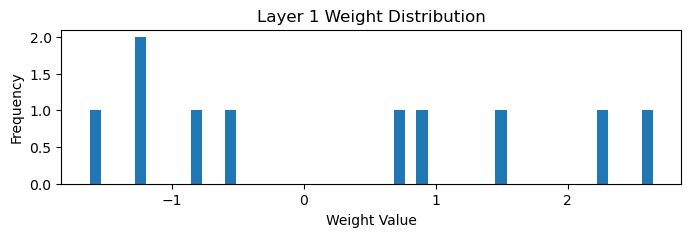

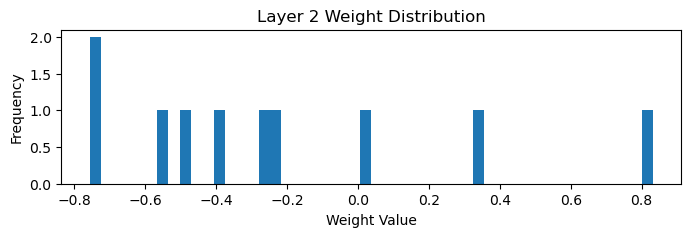

Epoch 1000:


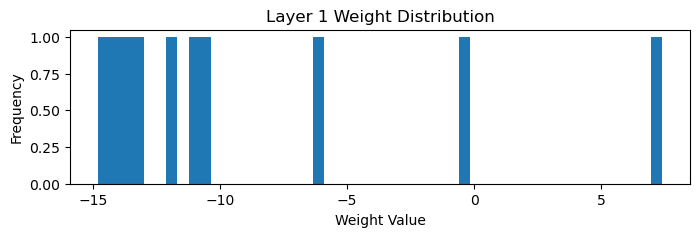

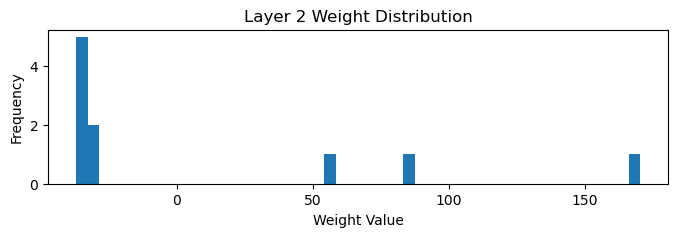

Epoch 2000:


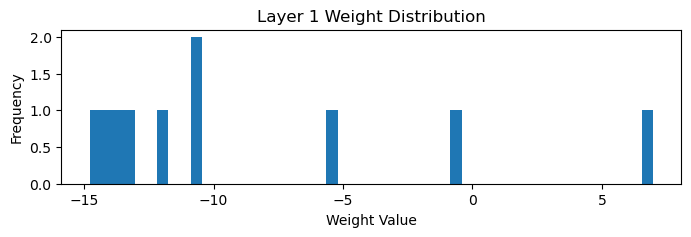

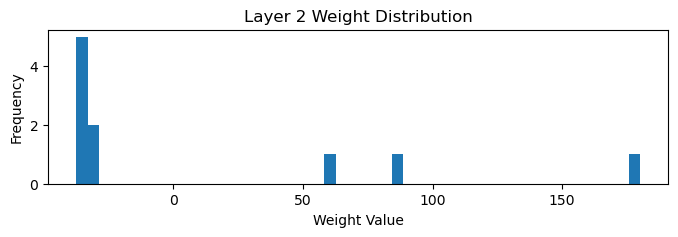

In [267]:
mlp_best = MLP([1, 10, 1], init_method='he')
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square, y_train_square)]
mlp_best.train(training_data, epochs=3000, learning_rate=0.03, batch_size=10, plot_interval=1000, lambda_=0.1)

In [268]:
predictions = np.array([mlp_best.feedforward(x.reshape(-1, 1))[0] for x in X_test_square])

# Flatten predictions to ensure it has the same shape as y_test
predictions = predictions.reshape(-1, 1)

for i in range(len(predictions)):
    print(predictions[i], y_test_square[i])
mse_score = calculate_mse(predictions, y_test_square)

print(f"MSE Score: {mse_score}")

[-31.29512263] [-43.4869178]
[22.73689522] [3.7528081]
[-121.86873978] [-128.61072132]
[4.86274259] [5.67182845]
[-27.87341752] [-27.46916942]
[35.30588133] [36.53905322]
[-50.02189922] [-56.38035958]
[167.60279857] [163.71667642]
[-111.23772498] [-109.92253645]
[-31.84572208] [-43.87280887]
[-37.84771613] [-36.76289151]
[-115.95637124] [-117.96377078]
[4.47699805] [5.24004298]
[-120.94537023] [-128.71571315]
[-60.06188117] [-61.08193105]
[2.42927962] [2.94504249]
[-64.089752] [-66.12375418]
[46.62215447] [45.94659944]
[-20.09001385] [-35.44343445]
[-59.295788] [-60.21294992]
[155.56751342] [152.56039396]
[-114.60699071] [-113.61118977]
[-98.37657997] [-96.92892366]
[-70.70786211] [-70.87526302]
[-117.23337695] [-117.45634919]
[-57.66702822] [-61.6352831]
[-121.95369499] [-129.40068949]
[-115.06352465] [-116.2889997]
[-3.43375088] [-22.4051127]
[-62.75454235] [-65.18253908]
[-30.65610155] [-30.00706095]
[-121.47669981] [-129.69254744]
[-121.52921245] [-129.76750355]
[-121.53408356] [-1

Epoch 0:


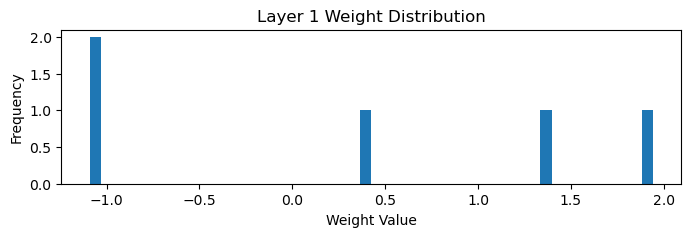

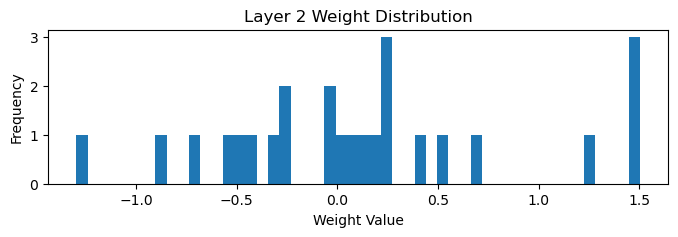

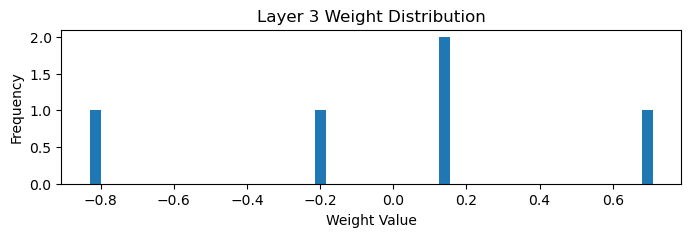

Epoch 100:


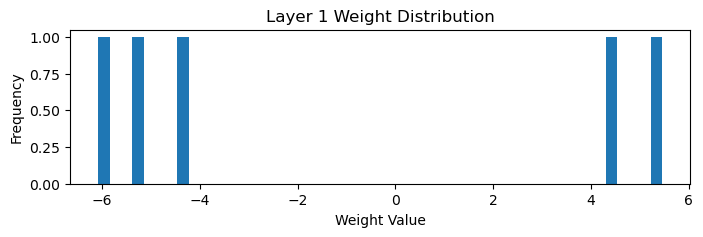

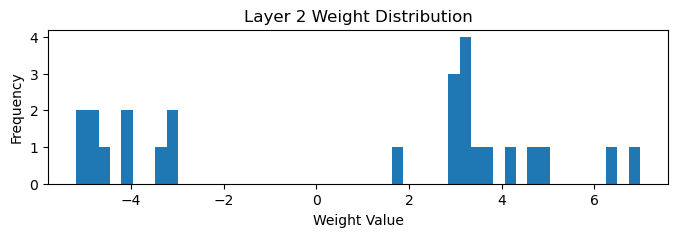

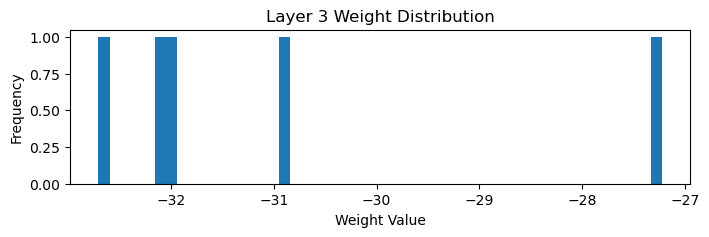

Epoch 200:


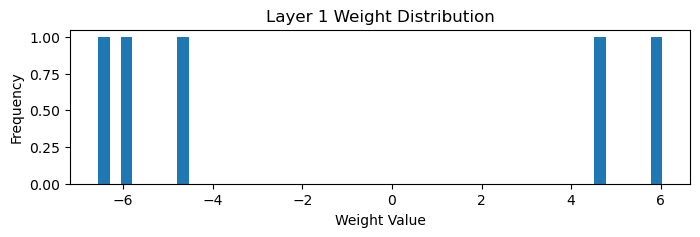

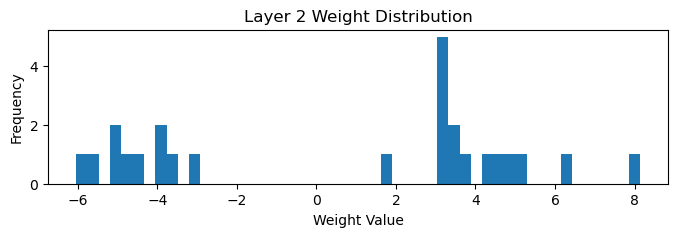

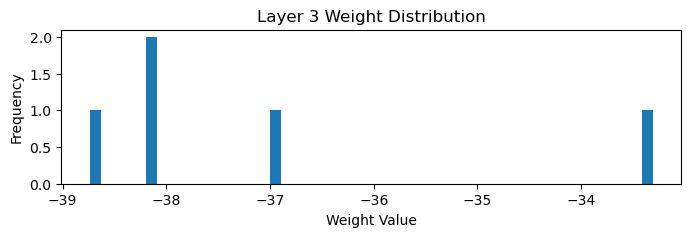

Epoch 300:


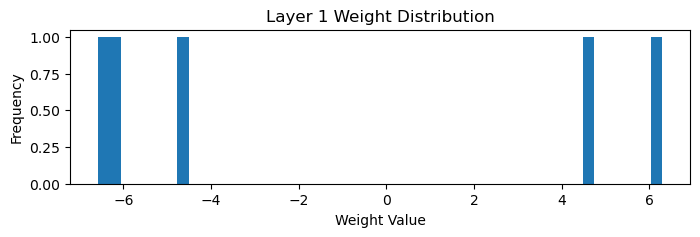

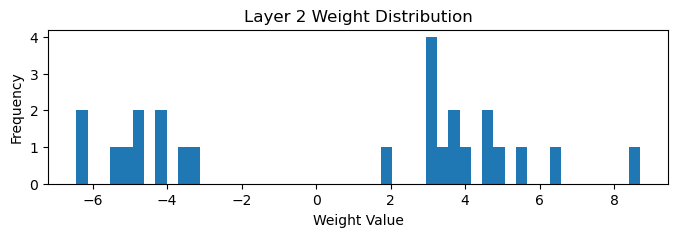

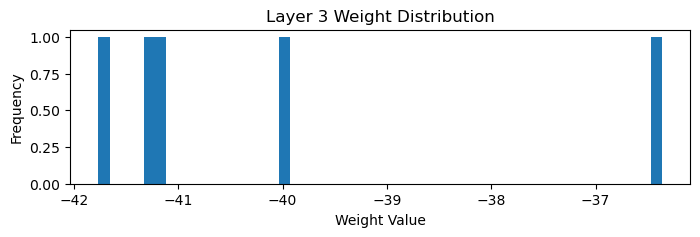

Epoch 400:


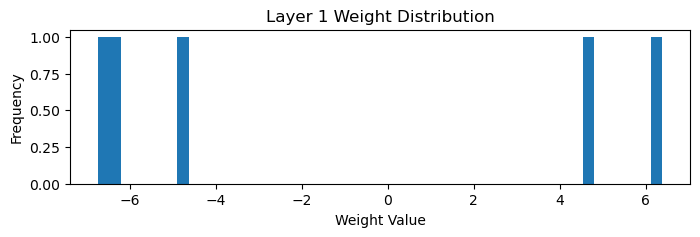

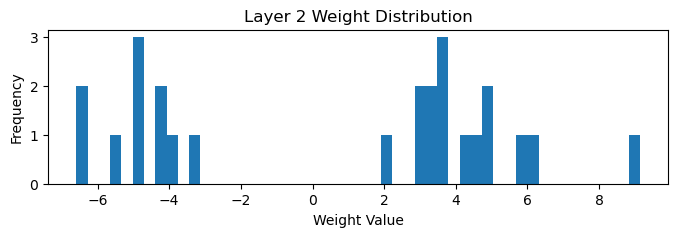

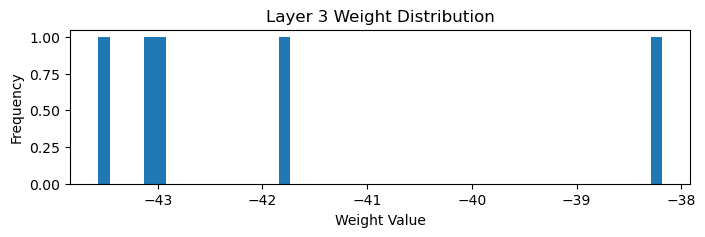

Epoch 500:


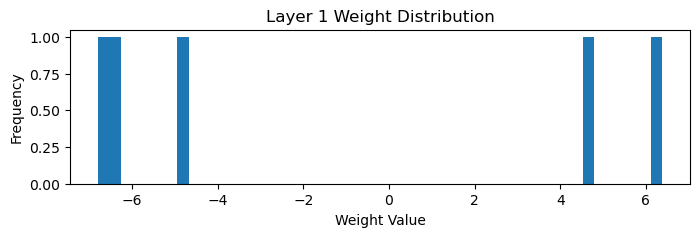

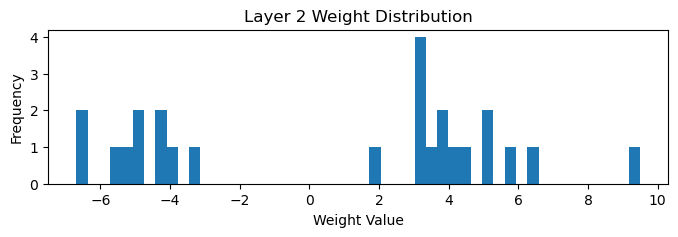

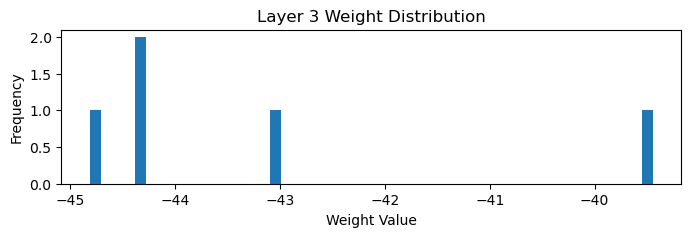

Epoch 600:


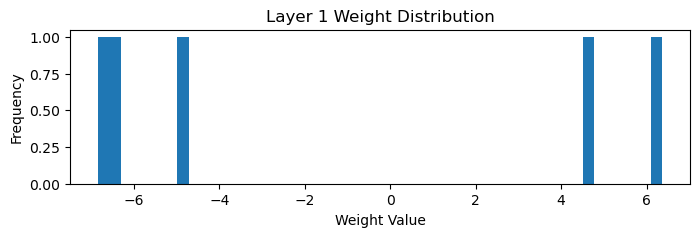

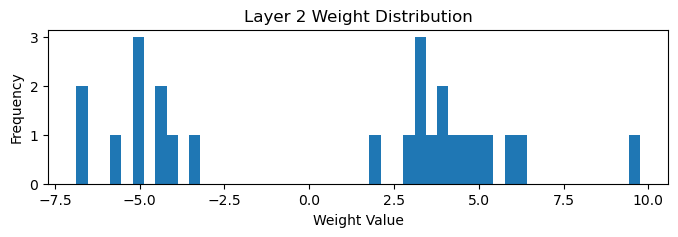

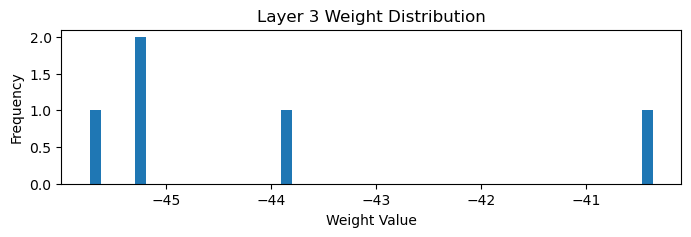

Epoch 700:


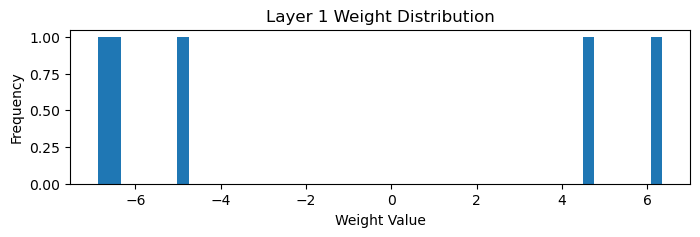

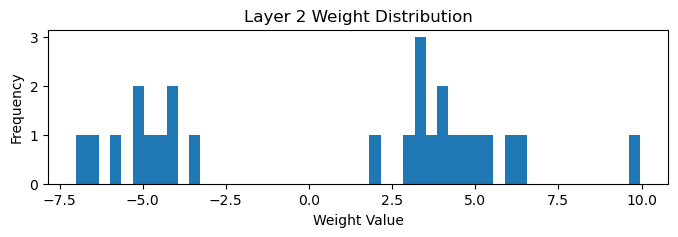

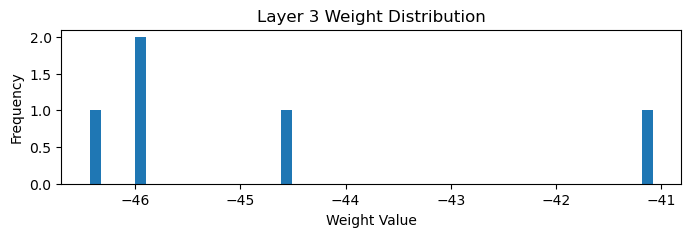

Epoch 800:


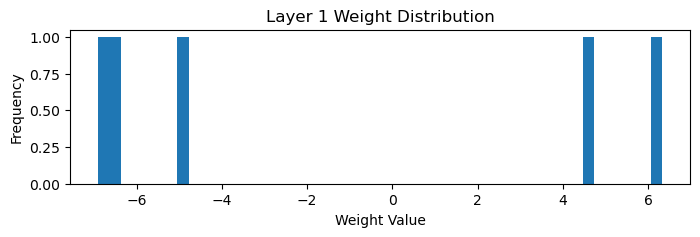

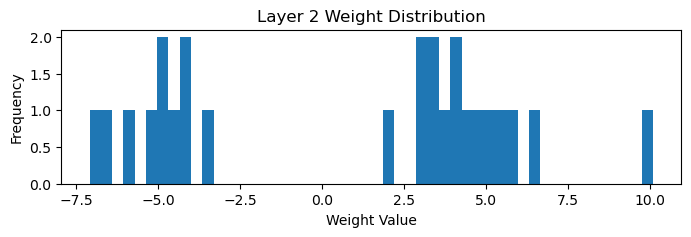

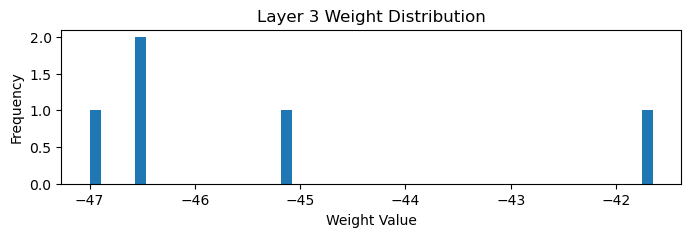

Epoch 900:


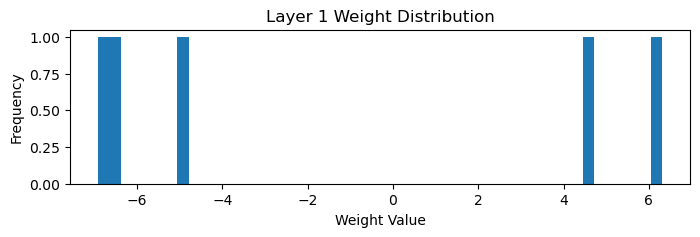

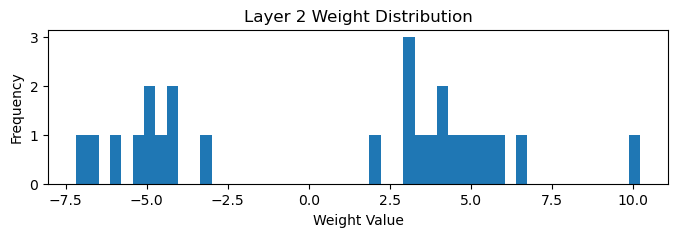

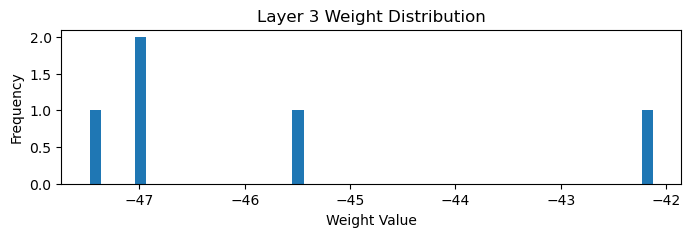

In [255]:
mlp_square_1_5 = MLP([1, 5, 5, 1])
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_square, y_train_square)]
mlp_square_1_5.train(training_data, epochs=1000, learning_rate=0.01, batch_size=10, plot_interval=100)

In [256]:
predictions = np.array([mlp_square_1_5.feedforward(x.reshape(-1, 1))[0] for x in X_test_square])

# Flatten predictions to ensure it has the same shape as y_test
predictions = predictions.reshape(-1, 1)

for i in range(len(predictions)):
    print(predictions[i], y_test_square[i])
mse_score = calculate_mse(predictions, y_test_square)

print(f"MSE Score: {mse_score}")

[-77.57559254] [-43.4869178]
[-77.57559313] [3.7528081]
[-77.5746747] [-128.61072132]
[4.69684156] [5.67182845]
[-26.00613884] [-27.46916942]
[36.74855463] [36.53905322]
[-77.57559208] [-56.38035958]
[152.25317281] [163.71667642]
[-77.57557479] [-109.92253645]
[-77.57559253] [-43.87280887]
[-34.85046534] [-36.76289151]
[-77.57555677] [-117.96377078]
[4.26355298] [5.24004298]
[-77.5754143] [-128.71571315]
[-64.55687842] [-61.08193105]
[1.97700844] [2.94504249]
[-77.5755915] [-66.12375418]
[-77.57559325] [45.94659944]
[-77.57559272] [-35.44343445]
[-63.55058396] [-60.21294992]
[150.2769988] [152.56039396]
[-77.56488045] [-113.61118977]
[-77.4678917] [-96.92892366]
[-77.5755911] [-70.87526302]
[-77.56918851] [-117.45634919]
[-77.5755918] [-61.6352831]
[-77.5749095] [-129.40068949]
[-77.57556209] [-116.2889997]
[-77.57559292] [-22.4051127]
[-77.57559157] [-65.18253908]
[-28.32490689] [-30.00706095]
[-77.57532614] [-129.69254744]
[-77.57531235] [-129.76750355]
[-77.57421745] [-127.04872533]

## STEPS SMALL

In [5]:
df_train_steps = pd.read_csv('mio1/regression/steps-small-training.csv')
X_train_steps = df_train_steps['x'].values.reshape(-1, 1)
y_train_steps = df_train_steps['y'].values.reshape(-1, 1)

df_test_steps = pd.read_csv('mio1/regression/steps-small-test.csv')
X_test_steps = df_test_steps['x'].values.reshape(-1, 1)
y_test_steps = df_test_steps['y'].values.reshape(-1, 1)

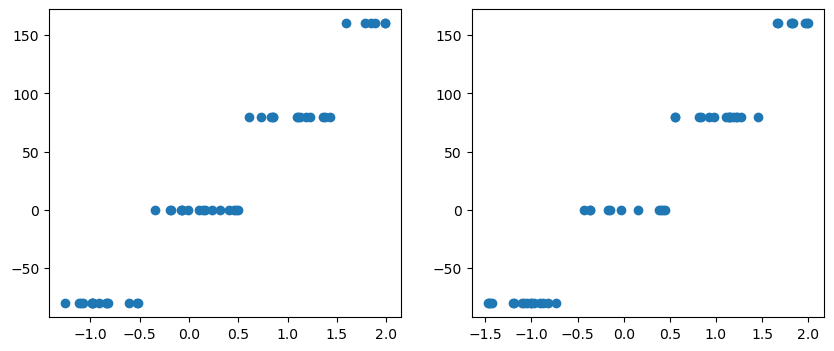

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_train_steps, y_train_steps)


plt.subplot(1, 2, 2)
plt.scatter(X_test_steps, y_test_steps)
plt.show()